In [3]:
include("models/ppl/main.jl")
using CairoMakie
struct HistoryType
    # policies::Dict{Int, Vector{Policy}}
    mean_rewards::Dict{Int, Vector{Float64}}
    name::String
    info::Dict
end

In [4]:
using JSON3
using Serialization

function load_history_from_json(file_path::String)::HistoryType
    json_data = JSON3.read(file_path)
    mean_rewards = Dict{Int, Vector{Float64}}(
        parse(Int, string(k)) => Float64.(v) for (k, v) in json_data["mean_rewards"]
    )
    name = json_data["info"]["name"]
    # info = Dict(json_data["info"])
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return HistoryType(mean_rewards, name, info)
end


load_history_from_json (generic function with 1 method)

In [5]:
histories = Dict(
    :Simple => load_history_from_json("json/dirichlet/history/Simple.json"),
    :Medium => load_history_from_json("json/dirichlet/history/Medium.json"),
    :None => load_history_from_json("json/dirichlet/history/None.json"),
    :Softmax => load_jld("data/mcmc/history/SoftmaxPPL.jld"),
    :SimplePPL => load_jld("data/mcmc/history/SimplePPL.jld"),
    :DQN => load_history_from_json("json/dqn/history/DQN.json"),
)

Dict{Symbol, Any} with 6 entries:
  :DQN       => HistoryType(Dict(64=>[-0.55991, -0.61872, -0.61861], 16=>[-0.55…
  :Softmax   => PPHistoryRun("SoftmaxPPL", MCMCModel(:Softmax, DynamicChoiceMap…
  :None      => HistoryType(Dict(16=>[-0.663, -0.634, -0.6236, -0.6881, -0.6865…
  :Medium    => HistoryType(Dict(16=>[-0.5974, -0.5614, -0.5156, -0.5595, -0.52…
  :SimplePPL => PPHistoryRun("SimplePPL", MCMCModel(:SimplePPL, DynamicChoiceMa…
  :Simple    => HistoryType(Dict(16=>[-0.383, -0.3707, -0.3729, -0.3825, -0.345…

In [4]:
# using JSON3

# function save_ts_to_json(ts_instance::HistoryType, file_path::String)
#     json_data = Dict(
#         "mean_rewards" => ts_instance.mean_rewards,
#         "name" => ts_instance.name,
#         "info" => ts_instance.info
#     )
#     JSON3.write(file_path, json_data)
# end


In [5]:

# using PyCall
# sepsis_gym = pyimport("custom_sepsis")

# mean_rewards = Dict()
# for len in 1:100000000
#     if log2(len) % 1 != 0
#         continue
#     end
#     mean_rewards[len] = [sepsis_gym.train_dqn(sepsis_gym.true_env, len, len).evaluate_policy(100000) for _ in 1:3]
#     history = HistoryType(mean_rewards, "DQN", Dict("name" => "DQN"))
#     save_ts_to_json(history, "json/dqn/history/DQN.json")
# end


In [6]:
random_mean = -0.6662000000000002 # mean([sepsis_gym.evaluate_policy(sepsis_gym.random_policy(), 1000) for i in 1:100])

-0.6662000000000002

In [7]:
function moving_avg(data, window_size=100)
    half_window = div(window_size, 2)
    
    # Pad the data with the edge values to handle borders
    padded_data = vcat(data[1:half_window], data, data[end-half_window:end])
    
    # Compute the moving average using a sliding window
    smoothed = [mean(padded_data[i:i+window_size-1]) for i in 1:length(data)]
    
    return smoothed
end


moving_avg (generic function with 2 methods)

In [8]:
using CairoMakie
using Statistics

# Example: Assuming you have 5 different dictionaries stored in a list

function plot_histories(histories, window_size=1, labels=[:SimplePPL, :Softmax, :Simple, :Medium, :None, :DQN], x_lim=nothing)

    # Create a figure
    fig = Figure(resolution = (800, 600))
    ax = Axis(fig[1, 1], xscale=log10, xlabel = "History Size (Number of Episodes)", ylabel = "Mean Rewards Across 100'000 Episodes", title = "Mean Rewards for 10 Sample MDPs Conditioned on a History")

    # Define colors for each dataset

    # Plot each dataset
    for (i, type) in enumerate(labels)
        mean_rewards = histories[type].mean_rewards
        # Prepare data
        x_vals = sort(collect(keys(mean_rewards)))
        y_means = [mean(mean_rewards[x]) for x in x_vals]
        y_stds = [std(mean_rewards[x]) for x in x_vals]

        # Collect all (x, y) pairs for scatter
        scatter_x = []
        scatter_y = []
        for x in x_vals
            ys = mean_rewards[x]
            append!(scatter_x, fill(x, length(ys)))  # Repeat x for each y
            append!(scatter_y, ys)                  # Collect y values
        end

        smoothed_mean_rewards = moving_avg(y_means, window_size)
        smoothed_std_rewards = Float64.(moving_avg(y_stds, window_size))


        # Add scatter plot for all points
        scatter!(ax, scatter_x, scatter_y, color = (colors_dict[type], 0.2), label = label_dict[type])

        # Add error band (variance) at the mean points
        band!(ax, x_vals, smoothed_mean_rewards .- smoothed_std_rewards, smoothed_mean_rewards .+ smoothed_std_rewards, color = (colors_dict[type], 0.2), )

        # Add line for the mean points
        # lines!(ax, x_vals, smoothed_mean_rewards, color = colors_dict[type], label = label_dict[type])
    end
    if x_lim != nothing
        xlims!(ax, 1, x_lim)
    end

    # Add a legend
    axislegend(ax, position=(:right, :bottom))



    # Display the plot
    fig
end


plot_histories (generic function with 4 methods)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


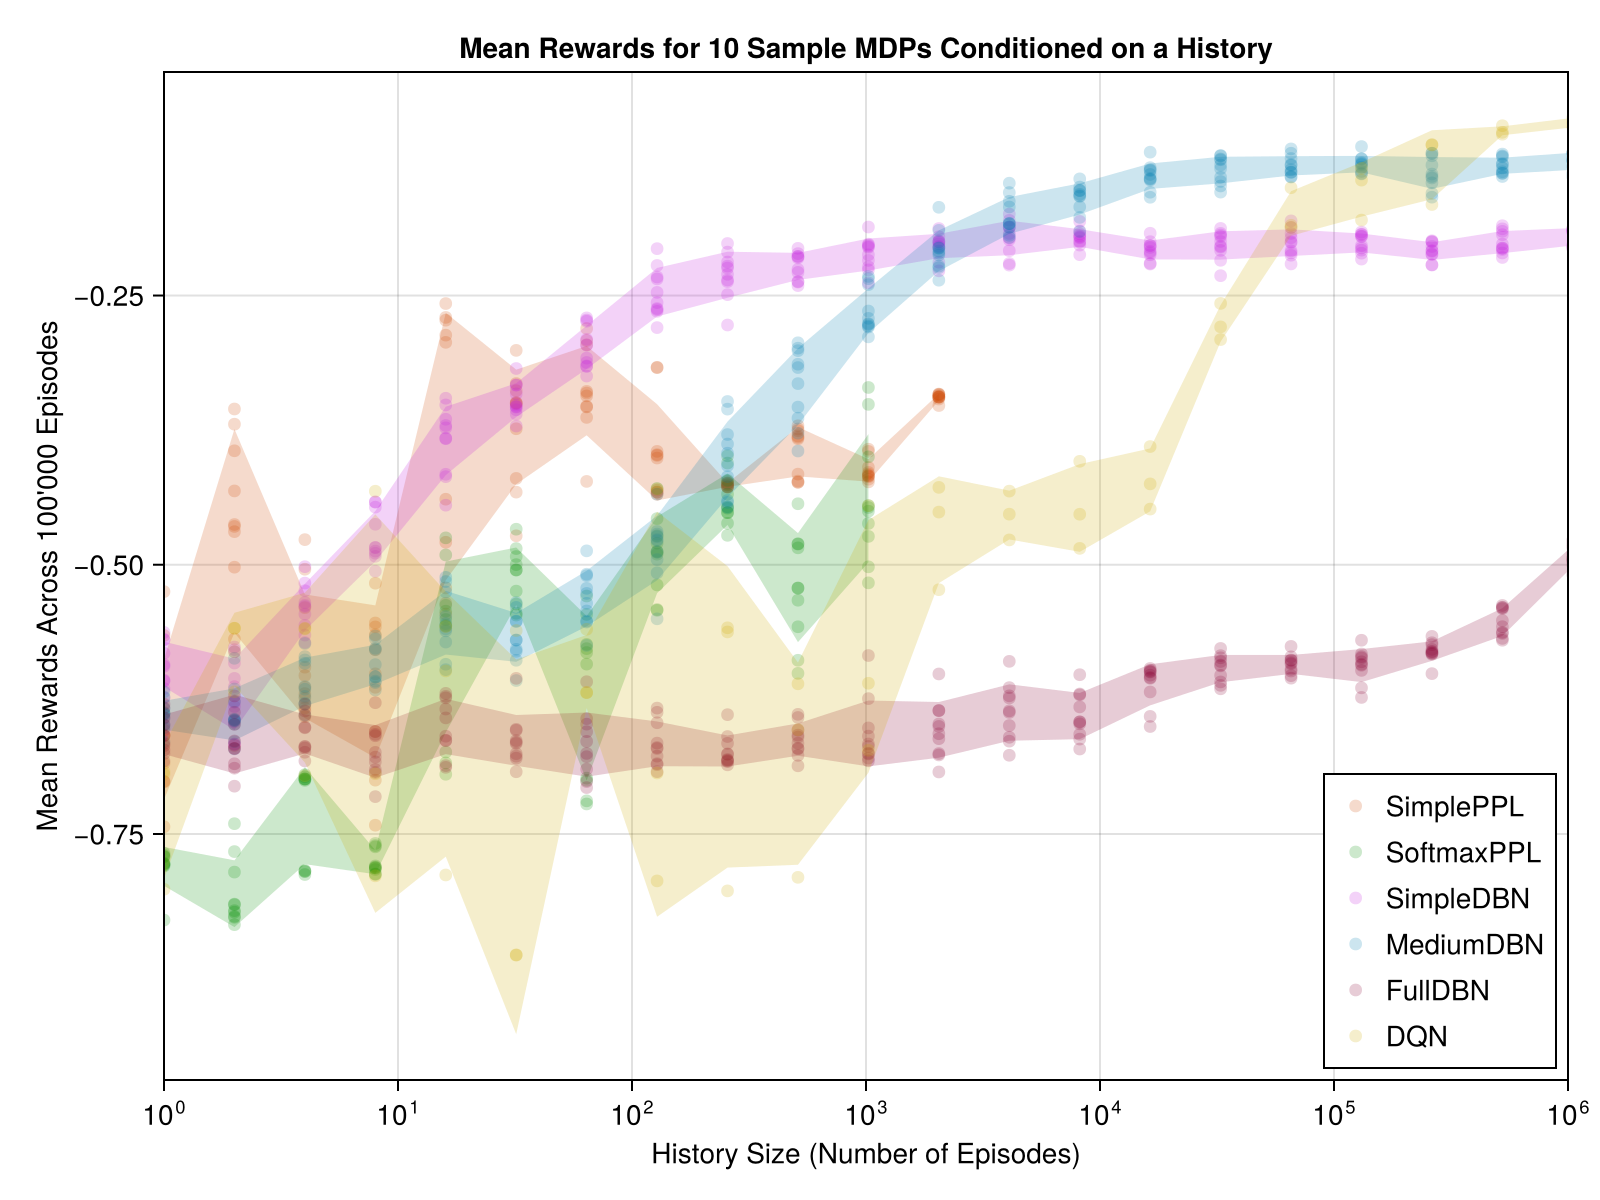

In [21]:
plot_histories(histories, 1, [:SimplePPL, :Softmax, :Simple, :Medium, :None, :DQN], 1000000)

In [9]:
function plot_scores(model)
    ks = sort(collect(keys(model.models)))
    fig = Figure()
    ax = Axis(fig[1, 1])

    # for k in ks
        lines!(ax, model.models[ks[end]].scores, label=string(ks[end]))
    # end

    axislegend(ax, position=(:right, :bottom))
    fig
    
end

plot_scores (generic function with 1 method)

In [17]:
finer = Dict(
    :Softmax => load_jld("data/mcmc/history/SoftmaxPPL-finer.jld"),
    :SimplePPL => load_jld("data/mcmc/history/SimplePPL-finer.jld"),
)

Dict{Symbol, PPHistoryRun} with 2 entries:
  :Softmax   => PPHistoryRun("SoftmaxPPL-finer", MCMCModel(:Softmax, DynamicCho…
  :SimplePPL => PPHistoryRun("SimplePPL-finer", MCMCModel(:SimplePPL, DynamicCh…

In [61]:
indices = [ 2,3,4,6,10,16,25,40,63,100]

10-element Vector{Int64}:
   2
   3
   4
   6
  10
  16
  25
  40
  63
 100

In [62]:
independent_histories = Dict(
    :Softmax => Dict(i => [load_jld("data/mcmc/history/SoftmaxPPL-$(i)-$(j).jld") for j in 1:5] for i in indices),
    :SimplePPL => Dict(i => [load_jld("data/mcmc/history/SimplePPL-$(i)-$(j).jld") for j in 1:5] for i in indices) 
)

Dict{Symbol, Dict{Int64, Vector{PPHistoryRun}}} with 2 entries:
  :Softmax   => Dict(4=>[PPHistoryRun("SoftmaxPPL-4-1", MCMCModel(:Softmax, Dyn…
  :SimplePPL => Dict(4=>[PPHistoryRun("SimplePPL-4-1", MCMCModel(:SimplePPL, Dy…

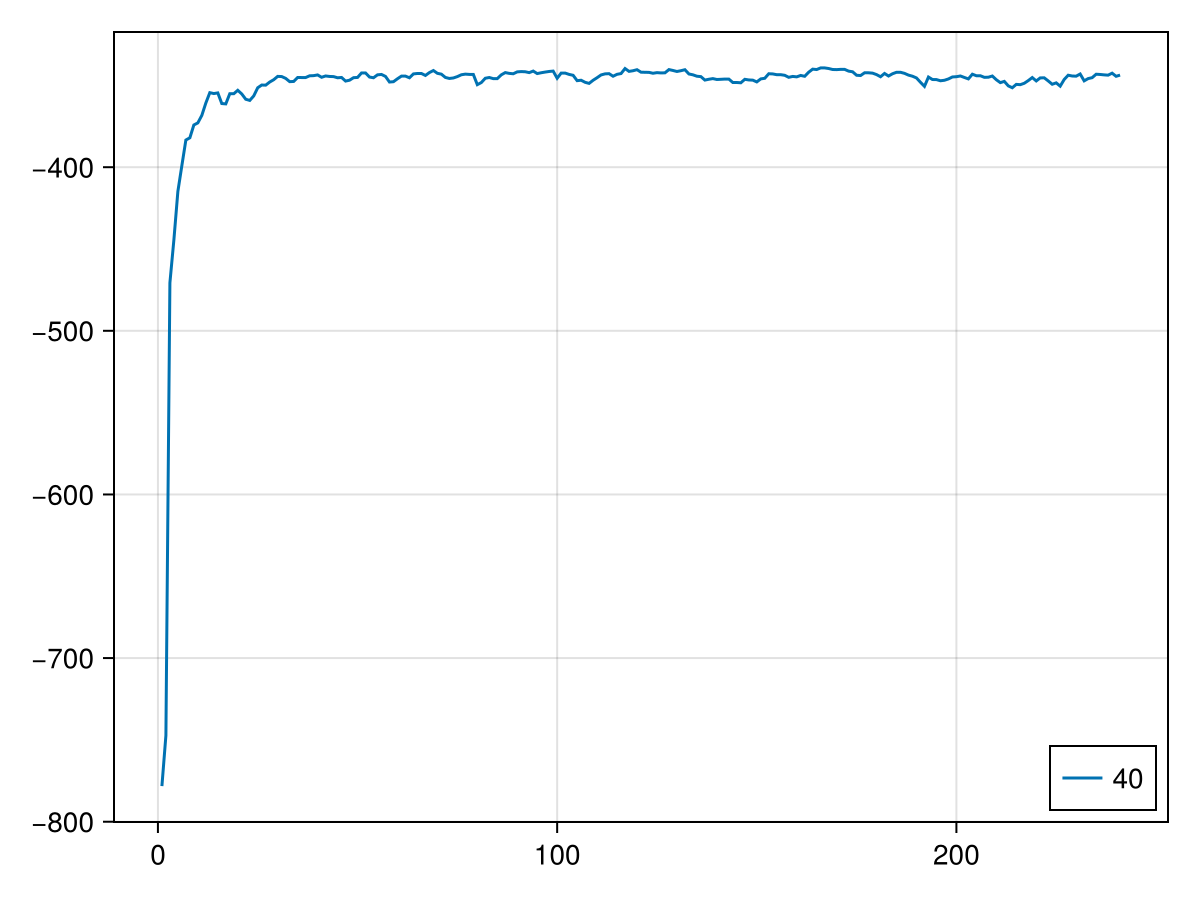

In [63]:
plot_scores(independent_histories[:SimplePPL][40][1])

In [64]:
independent = Dict(
    :SimplePPL => HistoryType(
        Dict(i => [model.mean_rewards[i][1] for model in independent_histories[:SimplePPL][i]] for i in indices),
        "SimplePPL",
        Dict("name" => "SimplePPL")
    ),
    :Softmax => HistoryType(
        Dict(i => [model.mean_rewards[i][1] for model in independent_histories[:Softmax][i]] for i in indices),
        "Softmax",
        Dict("name" => "Softmax")
    ))

Dict{Symbol, HistoryType} with 2 entries:
  :Softmax   => HistoryType(Dict(4=>[-0.77499, -0.77668, -0.76265, -0.46986, -0…
  :SimplePPL => HistoryType(Dict(4=>[-0.29426, -0.42784, -0.39149, -0.3767, -0.…

In [65]:
with_indep = Dict(
    :Simple => histories[:Simple],
    :Medium => histories[:Medium],
    :None => histories[:None],
    :SimplePPL => independent[:SimplePPL],
    :Softmax => independent[:Softmax],
)

Dict{Symbol, HistoryType} with 5 entries:
  :Softmax   => HistoryType(Dict(4=>[-0.77499, -0.77668, -0.76265, -0.46986, -0…
  :None      => HistoryType(Dict(16=>[-0.663, -0.634, -0.6236, -0.6881, -0.6865…
  :Medium    => HistoryType(Dict(16=>[-0.5974, -0.5614, -0.5156, -0.5595, -0.52…
  :SimplePPL => HistoryType(Dict(4=>[-0.29426, -0.42784, -0.39149, -0.3767, -0.…
  :Simple    => HistoryType(Dict(16=>[-0.383, -0.3707, -0.3729, -0.3825, -0.345…

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


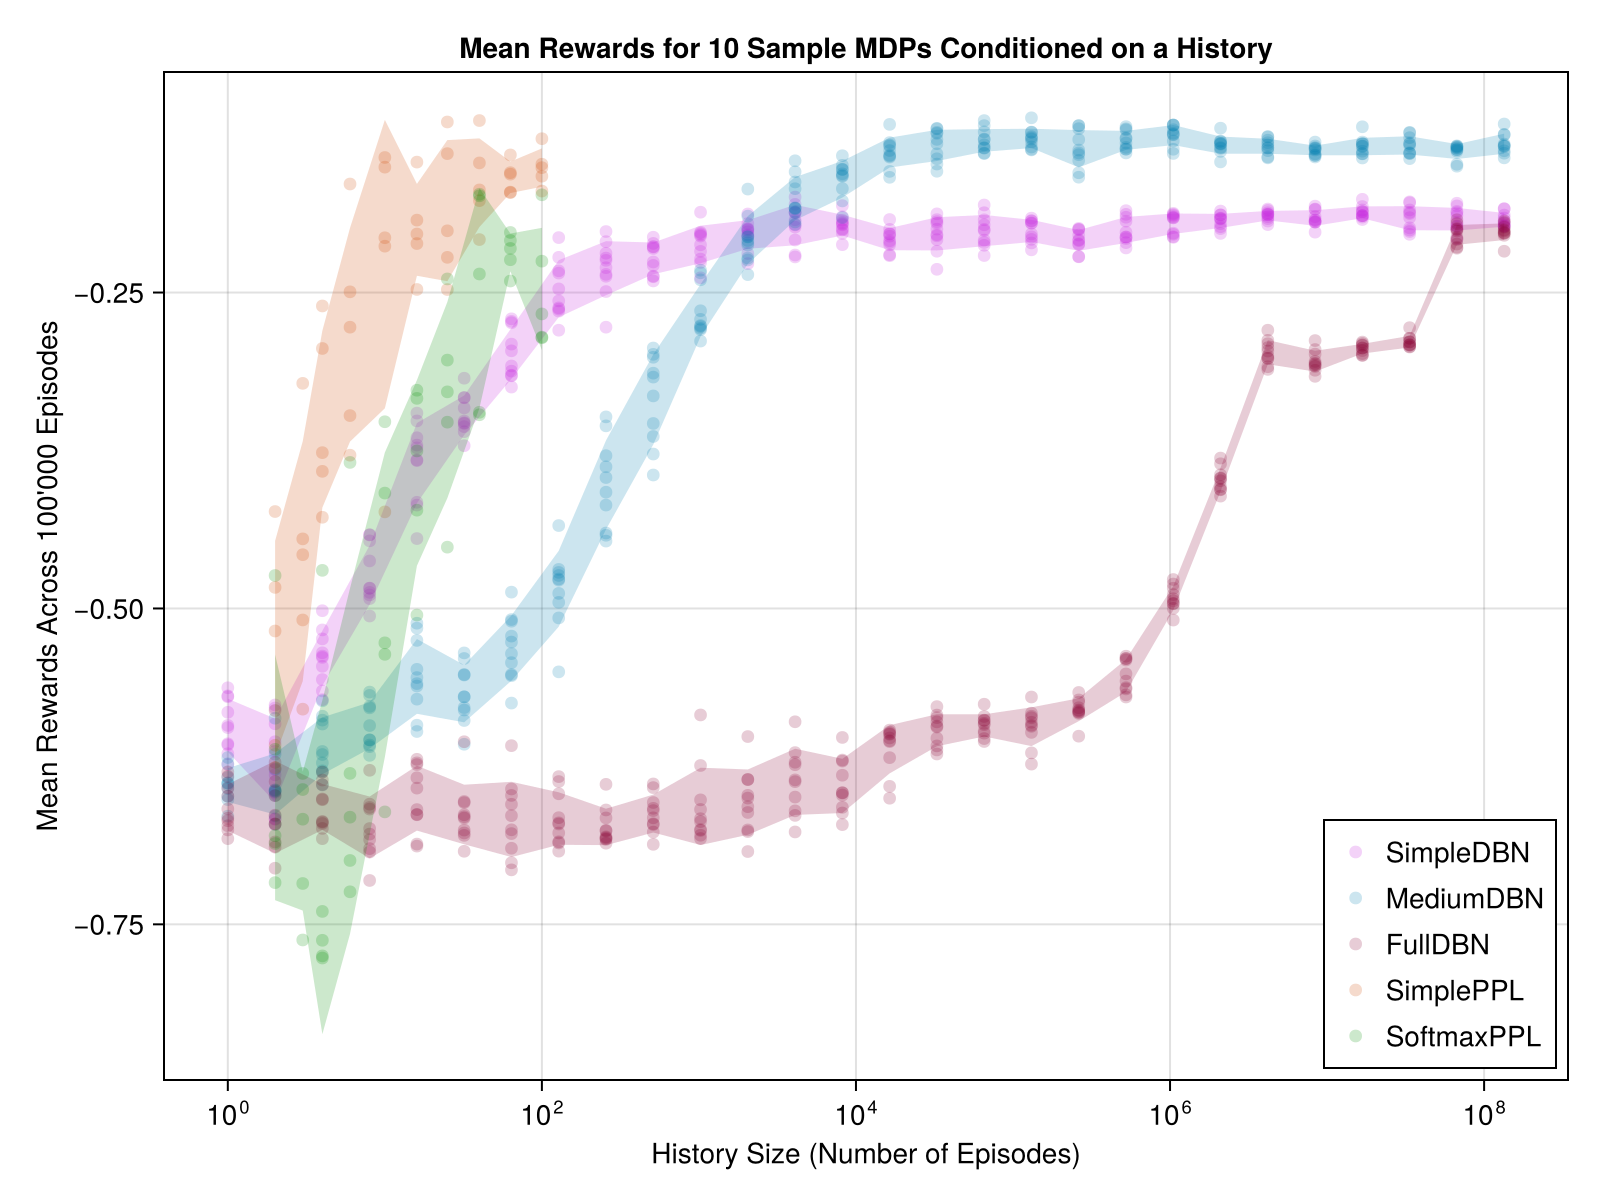

In [66]:
plot_histories(with_indep, 1, [:Simple, :Medium, :None, :SimplePPL, :Softmax])


15-element Vector{Int64}:
         1
         2
         4
         8
        16
        32
        64
       256
      1024
      4096
     16384
     65536
    262144
   1048576
 134217728

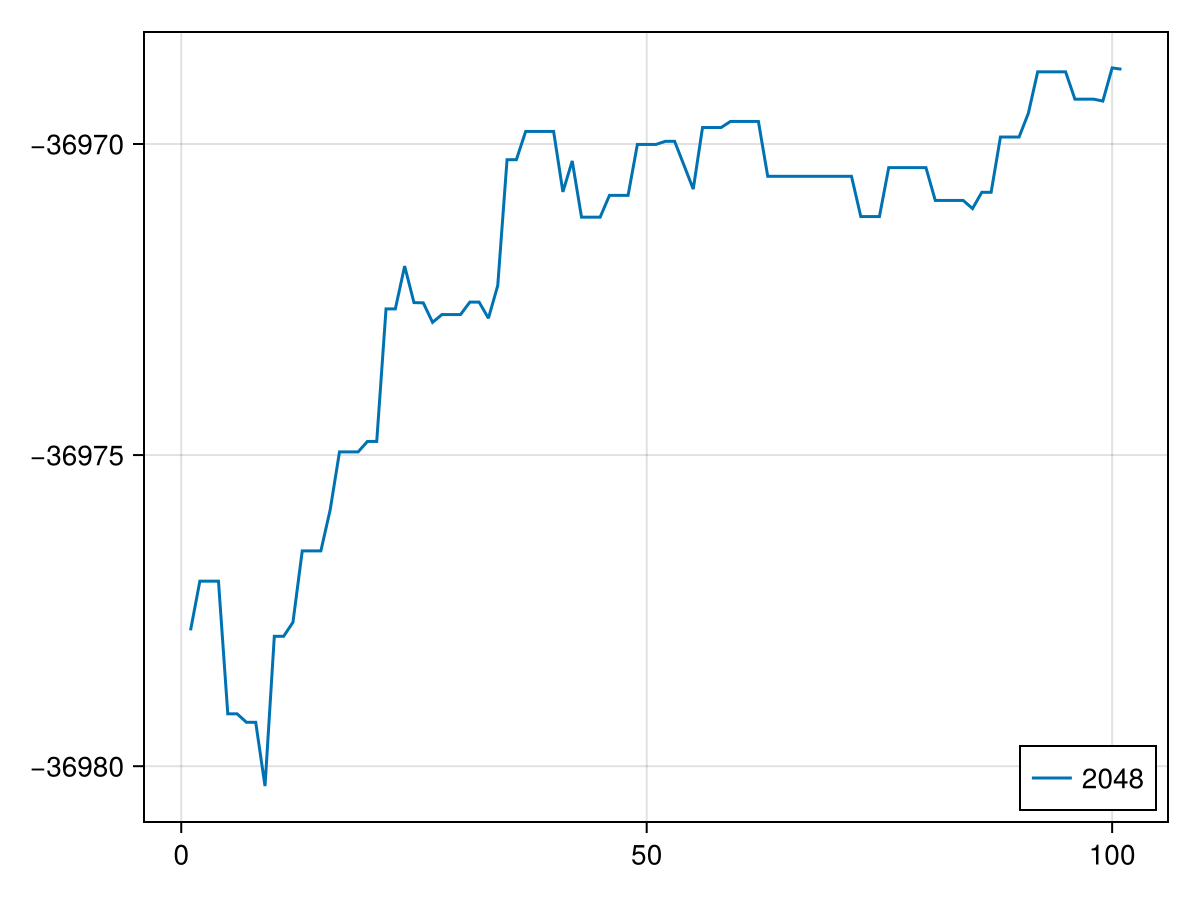

In [10]:
plot_scores(histories[:SimplePPL])

In [14]:
using Gen
nested_view(histories[:SimplePPL].model.choices)[:episodes]

2049

In [64]:
maximum(keys(histories[:SimplePPL].policies))

2048

In [65]:
length(histories[:SimplePPL].model.policies)

2049

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


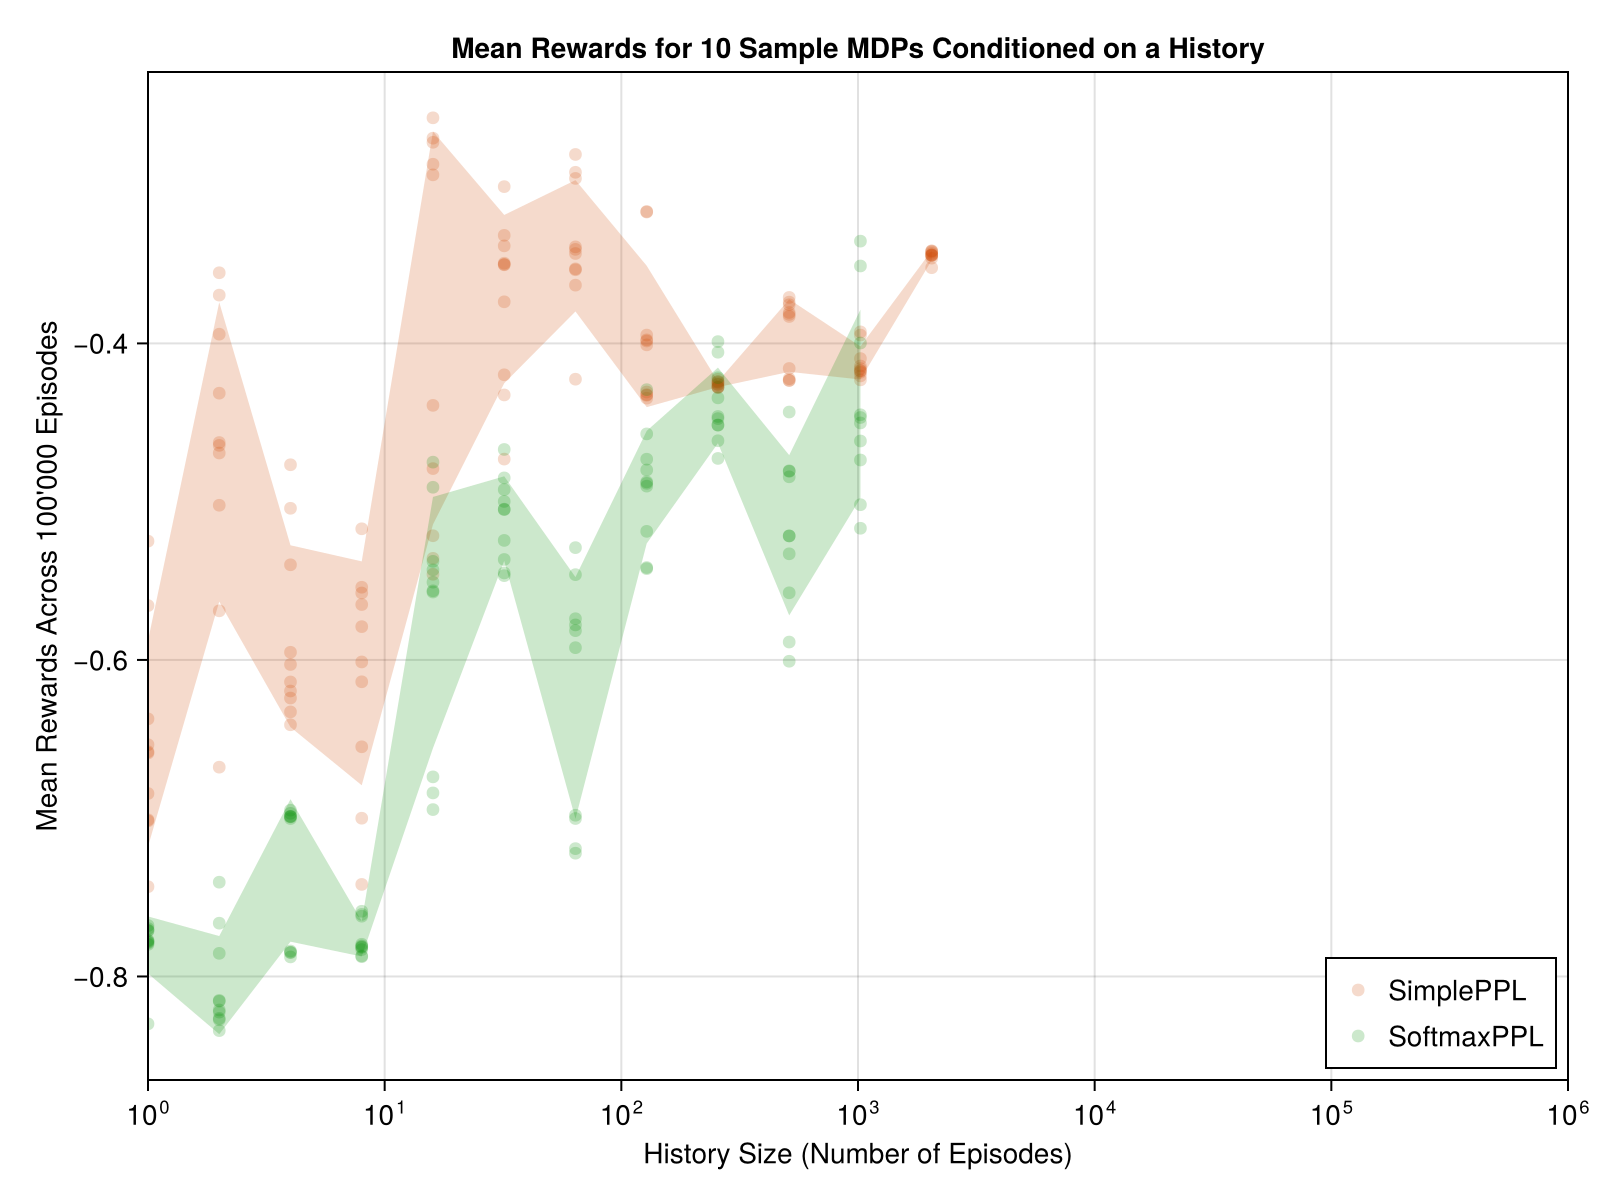

In [23]:
plot_histories(histories, 1, [:SimplePPL, :Softmax], 1000000)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


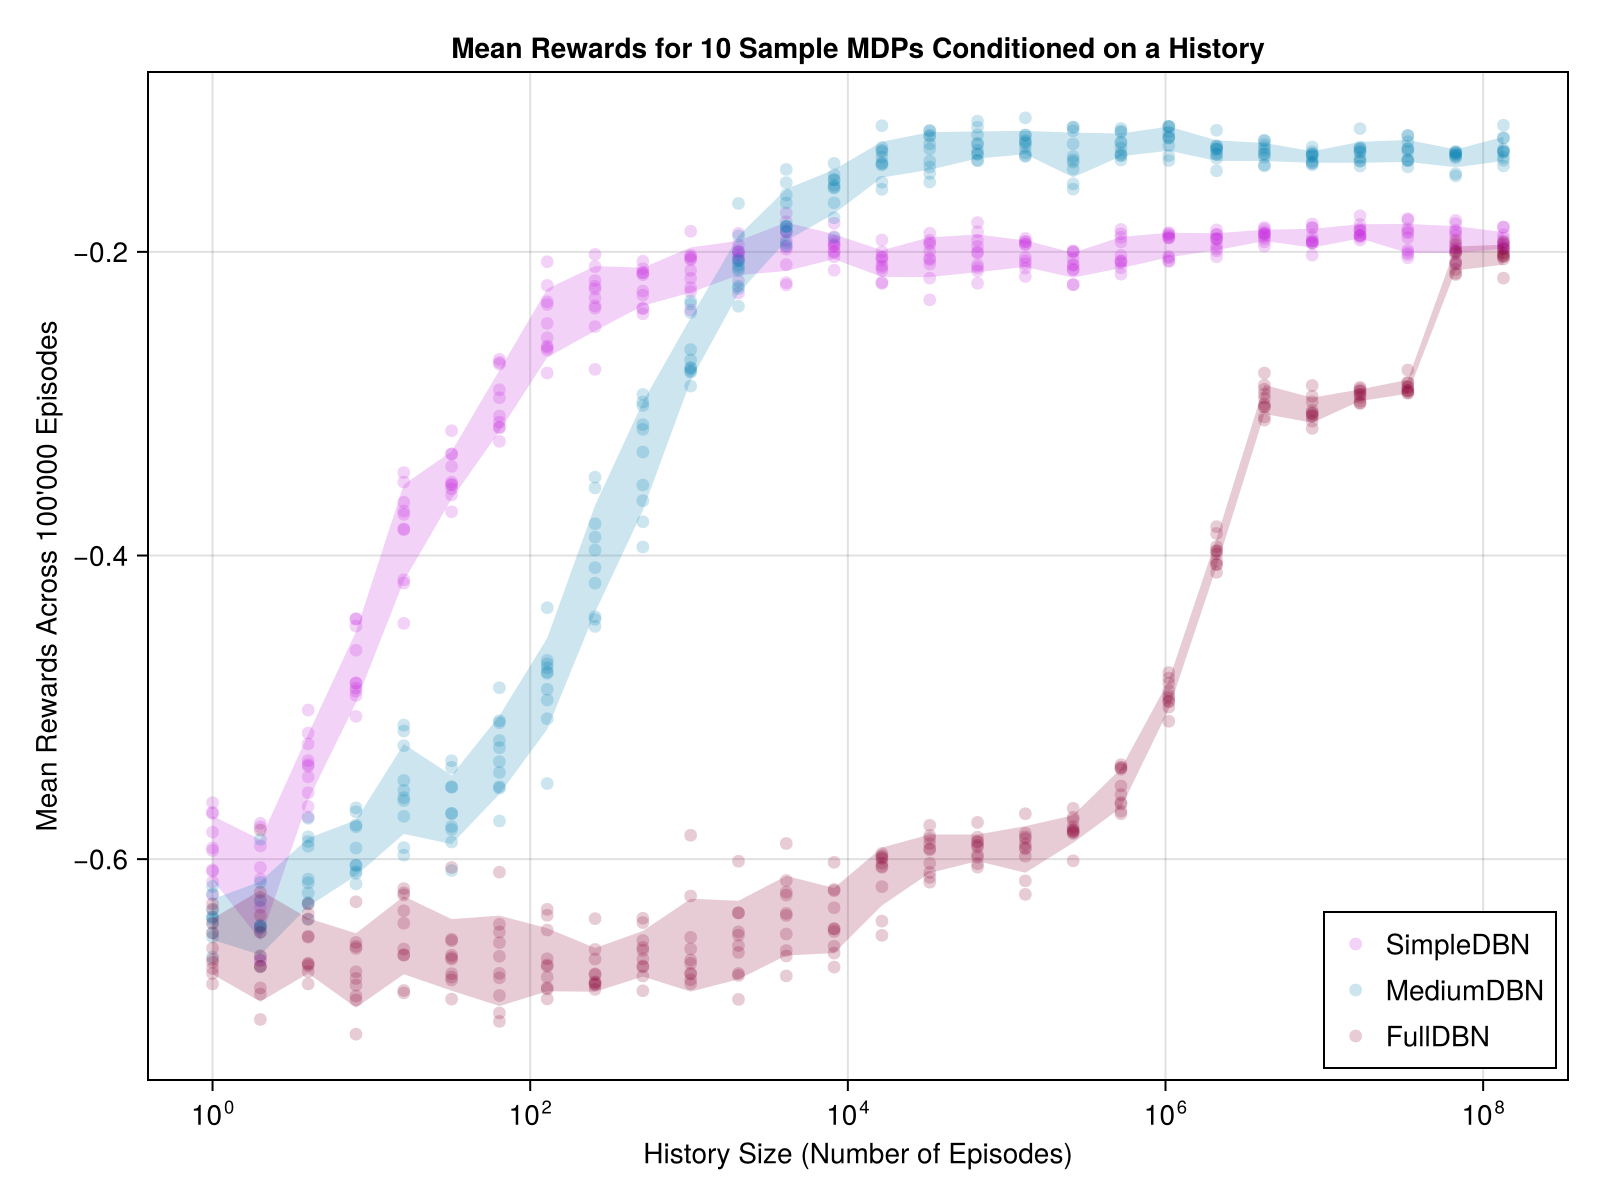

In [19]:
plot_histories(histories, 1, [:Simple, :Medium, :None])
